# Extracting Time Series Motifs

## install packages

In [ ]:
# !pip install llvmlite --ignore-installed
# !pip install sktime
# !pip install tslearn
# !pip install pandas==1.1.5

In [2]:
## prerequisites

In [3]:
#from helper import *

In [56]:
import numpy as np
import pandas as pd

from sktime.distances.elastic_cython import dtw_distance

# from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.barycenters import dtw_barycenter_averaging, dtw_barycenter_averaging_subgradient, softdtw_barycenter
# from tslearn.clustering import TimeSeriesKMeans, silhouette_score


# from sklearn.metrics import silhouette_samples

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import matplotlib.font_manager

from datetime import date


## Loading Data

In [62]:
def load_event_flows(file):
    df = pd.read_json(file, lines=True)
    df = df.melt(id_vars=["newspaper", "window_size"], var_name="event", value_name="time_series")
    df = df[df['newspaper'] != 'all']
    df = df[df.astype(str)['time_series'] != '[]'] #remove nan
    df['event_paper'] = df['event'] + '_' + df['newspaper']
    
    X = np.array(df['time_series'].values.tolist())
    #X_windowed = X[:,90-window:90+window]
    #print(X_windowed.shape)
    #df['time_series'] = X_windowed
    
    return df

    
def plot_helper(barycenter, window, labels=None):
    for series, label in zip(X, labels):
        plt.plot(series.ravel(), alpha=.4, label=label)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r-", linewidth=2.5)
    plt.xticks(range(0, (2*window + 1), 10), range(-1 * window, window +1, 10))
    #plt.legend()

    
def calculate_distance(p1, p2, window, normalization=False):
    event = np.array(df[df['event'] == p2]['time_series'].values.tolist())
    event = event[:,90-window:90+window]
    event = TimeSeriesScalerMeanVariance().fit_transform(event)
    if np.isnan(event).any():
        return np.nan
    else:
        event_average = softdtw_barycenter(event, max_iter=50, tol=1e-4)
    
    y = np.array(df[(df['newspaper'] == p1) & (df['event'] == p2)]['time_series'].values.tolist())
    if len(y) == 0:
        return np.nan
    y = y[:,90-window:90+window]
    y = TimeSeriesScalerMeanVariance().fit_transform(y)
    y = y[0,:,:]

 
    if len(event_average) == len(y):
        if len(event_average) != 0:
            return dtw_distance(event_average, y)
        else:
            return np.nan
    
    return dtw_distance(event_average, y)

def fix_event_name(name):
    name = name.replace('_', ' ')
    ## some manual replacements
    if name == 'Biafra':
        name = 'Nigerian Civil War'
    elif name == 'Retreat vietnam':
        name = 'Fall of Saigon'
    capitalized_name = []
    for word in name.split():
        if len(word) <= 2:
            if word == 'of':
                capitalized_name.append(word)
            else:
                capitalized_name.append(word.upper())
        else:
            capitalized_name.append(word.title())
    name = ' '.join(capitalized_name)
    return name  


## Viz settings

In [47]:
mpl.rcParams.update({"text.usetex": False,
                    "font.family": "Times New Roman",
                    "font.serif": "serif",
                     "font.size": 12,
                    "mathtext.fontset": "cm",
                    "axes.unicode_minus": False,
                    "axes.labelsize": 12,
                    "xtick.labelsize": 10,
                    "ytick.labelsize": 10,
                    "legend.fontsize": 10,
                    "axes.linewidth": 1
                    })

In [9]:
## settings

In [12]:
today = date.today()

In [60]:
df = load_event_flows('event_flow_90.json')

In [8]:
# selected_events  = [
# 'Eisenhower_president',
# 'Flood_NL',
# 'Suez_crisis',
# 'Earthquake_Chili',
# 'Coup_Ethiopia',
# 'Kennedy_inauguration',
# 'StartBerlin_Wall',
# 'Eichmann_execution',
# 'End_Cuba_Crisis',
# 'Coldest_winter',
# 'Pope_dies',
# 'Coup_Vietnam',
# 'riot_congo',
# 'Auschwitz_trial',
# 'Biafra',
# 'Tet_offensive',
# 'MLK_death',
# 'Nixon_candidate',
# 'Retreat_vietnam',
# 'biafra_end',
# 'bloody_sunday',
# 'olympic_munchen',
# 'yom_kippour',
# 'oil_crisis',
# 'palestinian_hostage',
# 'train_hostage',
# 'elfsteden',
# 'crash_747_tenerife',
# 'raf_death',
# 'wc_argentina',
# 'pope_dies',
# 'jones_town',
# 'snow_storms_nl',
# 'sjah_iran',
# 'harrisburg',
# 'salt2',
# 'hostage_iran',
# 'election_irak',
# 'ETA',
# 'Irak_iran_war',
# 'Reagan',
# 'reagan_inauguration',
# 'coup_surinam',
# 'protest_nuclear',
# 'protest_train',
# 'israel_bombs',
# 'van_agt_dissolve',
# 'nuclear_protest_vs',
# 'financial_crisis_latin_america',
# 'heineken',
# 'gulf_war_intensifies',
# 'iran_offensive',
# 'schengen',
# 'challenger',
# 'chernobyl',
# 'end_afghan_occupation_su',
# 'EC_nl',
# 'intifada',
# 'lockerbie',
# 'moon_landing',
# ]

## EXAMPLE DBA OF SPECIFIC EVENT

In [61]:
cluster = ['moon_landing']
window = 30

X = np.array(df[df['event'].isin(cluster)]['time_series'].values.tolist())
labels = df[df['event'].isin(cluster)]['newspaper'].values

X = TimeSeriesScalerMeanVariance().fit_transform(X)
X = X[:,90-window:90+window]
length_of_sequence = X.shape[1]

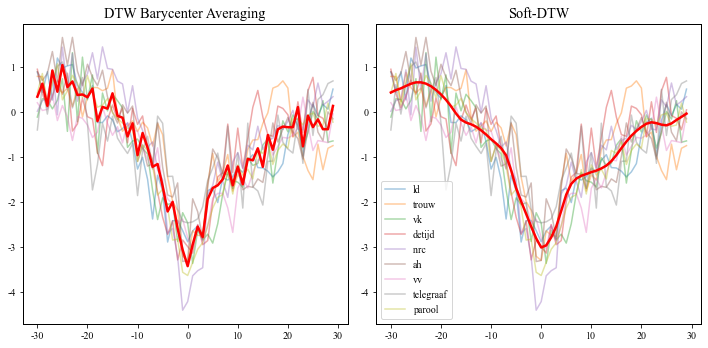

In [63]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)


ax1.title.set_text("DTW Barycenter Averaging")
ax1 = plot_helper(dtw_barycenter_averaging(X, max_iter=50, tol=1e-4), window, labels)

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text("Soft-DTW")
ax2 = plot_helper(softdtw_barycenter(X, gamma=1., max_iter=50, tol=1e-4), window, labels)


plt.tight_layout()
plt.legend()

plt.savefig(f'./figures/moon_landing_example_{today}.png', dpi=300, transparent=True, bbox_inches='tight')

## Mean Distance to Events Across Papers

In [15]:
#options
seed = 42
window = 30

In [11]:
#df = df[df['newspaper'].isin(['vk','parool', 'trouw'])]

In [12]:
# X = np.array(df[df['newspaper'] == 'vk']['time_series'].values.tolist())
# y = np.array(df['event_paper'].values.tolist())
# X = to_time_series_dataset(X)
# X = TimeSeriesScalerMeanVariance().fit_transform(X)


In [32]:
df.head()

,newspaper,window_size,event,time_series,event_paper
1,trouw,90,Eisenhower_president,"[0.24113255034032802, 0.24551132646161503, 0.2...",Eisenhower_president_trouw
2,vk,90,Eisenhower_president,"[0.295424883522862, 0.27766783086462904, 0.291...",Eisenhower_president_vk
3,detijd,90,Eisenhower_president,"[0.21867714207884803, 0.20452951762626, 0.1972...",Eisenhower_president_detijd
4,nrc,90,Eisenhower_president,"[0.22248676493162603, 0.20987084477435303, 0.2...",Eisenhower_president_nrc
5,ah,90,Eisenhower_president,"[0.13517179413344502, 0.138846547476167, 0.145...",Eisenhower_president_ah


In [35]:
event_list = df['event'].unique().tolist()
newspaper_list = df['newspaper'].unique().tolist()


#event_list = [event for event in event_list if event in selected_events]

dist_mat = np.asarray([[calculate_distance(p1, p2, window=window, normalization=True) for p2 in event_list] for p1 in newspaper_list])
matrix_dist = pd.DataFrame(dist_mat)

#event_list = [fix_event_name(event) for event in event_list]

matrix_dist.columns = event_list
matrix_dist.index = newspaper_list

matrix_dist.head()

,Eisenhower_president,Flood_NL,Suez_crisis,Earthquake_Chili,Coup_Ethiopia,Kennedy_inauguration,StartBerlin_Wall,Eichmann_execution,End_Cuba_Crisis,Coldest_winter,...,gulf_war_intensifies,iran_offensive,elfsteden,schengen,challenger,chernobyl,intifada,end_afghan_occupation_su,EC_nl,lockerbie
trouw,9.288028,6.202566,2.522172,26.096072,15.059146,12.737992,14.583124,7.233607,7.022448,5.951836,...,21.677814,35.173209,19.321637,9.546373,27.352813,16.890342,9.592875,11.233503,11.373685,27.062925
vk,8.682598,4.090387,2.144377,11.474384,14.865389,7.909910,6.706850,15.901588,10.213488,13.724070,...,28.087174,21.685839,22.328868,22.963635,12.380956,8.824372,9.808994,10.155166,9.518441,24.542145
detijd,8.220501,5.503468,1.124843,11.214325,23.984288,3.908352,6.486690,17.152254,4.452220,5.808544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nrc,4.425813,4.357334,3.103904,14.533798,21.834694,12.563233,9.601101,19.213707,6.788210,10.913102,...,10.033974,15.722031,18.514740,13.358995,20.243036,9.876114,13.539673,7.919925,17.070190,11.139346
ah,3.258410,10.298024,3.151773,15.641534,18.853290,8.236173,14.020056,18.155001,5.612631,10.241387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#cleaning of matrix

matrix_dist = matrix_dist.drop(['detijd', 'ah']) #these two papers didn't appear for the entire period
matrix_dist = matrix_dist.drop(['Pope_dies'], axis=1)

# sort matrix based on mean distance to event across newspapers
matrix_sorted = matrix_sorted.reindex(matrix_sorted.mean(axis=1).sort_values().index, axis=0)
matrix_sorted.columns = [fix_event_name(event) for event in matrix_sorted.columns]

Because the matrix cannot be visualized properly in the paper, we decided to only show the top records, and every second other from the remainder of the list.

In [38]:
matrix_sorted_selection = pd.concat([matrix_sorted.iloc[:, :10], matrix_sorted.iloc[:, 10::2]], axis=1)

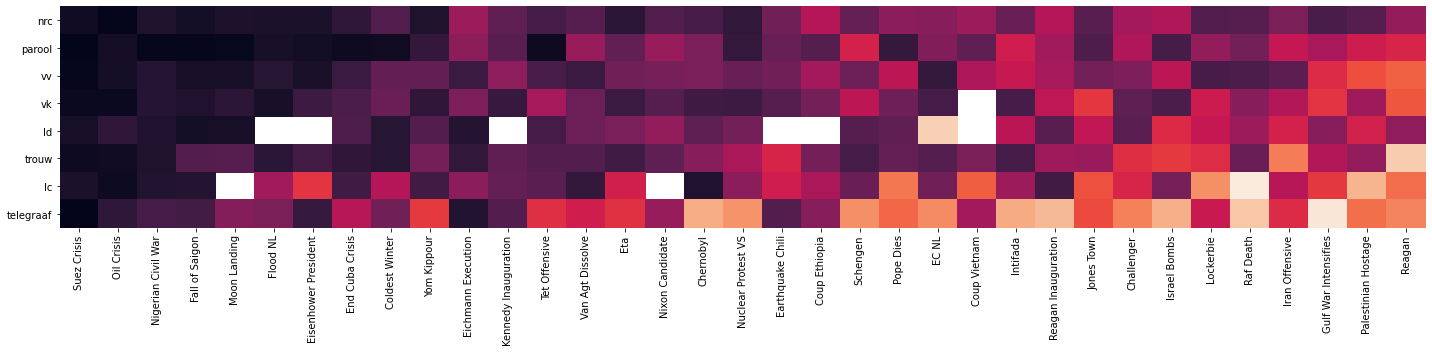

In [44]:
plt.figure(figsize=(20,5))
sns.heatmap(matrix_sorted_selection, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./figures/event_difference_{}.png'.format(today), 
            dpi=300, 
            bbox_inches='tight',
            transparent=True)



## Differences papers using random events

In [54]:
df = pd.read_json('./output/random_event_flow_30.json', lines=True)
df = df.melt(id_vars=["newspaper", "window_size"], 
         var_name="event", 
         value_name="time_series")

df = df[df['newspaper'] != 'all']
df = df[df.astype(str)['time_series'] != '[]']

In [55]:
years = []
dist_to_avg = []
newspapers = []


for i, group in df[(df['event'] > '1950')].groupby('event'):
    year = i.split('-')[0][2:3] + '0'
    X = np.array(group['time_series'].values.tolist())
    X = TimeSeriesScalerMeanVariance().fit_transform(X)
    group_average = dtw_barycenter_averaging(X, max_iter=50, tol=1e-4)
    for index, _ in enumerate(X):
        newspapers.append(group['newspaper'].values[index])
        years.append(year)
        dist_to_avg.append(dtw_distance(_, group_average))
        
df_random = pd.DataFrame(zip(years, dist_to_avg, newspapers), columns=['year', 'distance', 'newspaper'])

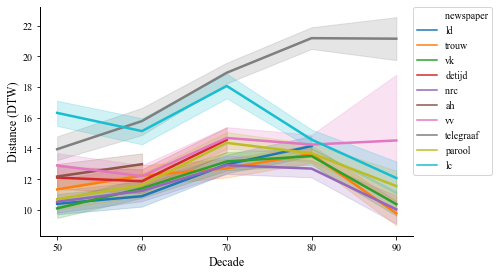

In [57]:
fig = plt.figure(1)
ax = fig.add_subplot(111)

ax = sns.lineplot(data=df_random, linewidth=2.5, x='year', y='distance', hue='newspaper')
sns.despine()
plt.xlabel('Decade')
plt.ylabel('Distance (DTW)')
plt.tight_layout()

lgd = ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
fig.savefig(f'./figures/newspaper_difference_{today}.png', dpi=300, bbox_inches='tight')

**FOR THE CLUSTERING SEE:**